# CitiBike TSP
**Algorithms Group 50**\
Donal Lowsley-Williams \
Joan La Rosa \
Isaac Lichter \
Weidong Gao 

We will be conducting the traveling salesman problem on New York City citibike data. We will be using each CitiBike station as the nodes in our graph, and represent the edge costs by the average time it takes to bike from one station to another. Edges will only include those rides in the CitiBike data that have actually occurred - in other words, if no ride in the data started at station A and ended at station B, we will not include that edge. This adds to the realism of the problem as it would be unlikely to take that edge anyways. Moreover, we will only have edges from one station to another - not one station to itself, as there are occurences of rides like this in the CitiBike data.

### Imports
Will we be implementing these algorithms by hand, so we just need libraries for data loading and export, matrix manipulation functions, and some data exploration. 

In [1]:
import csv
import json
import numpy as np
import pandas as pd
import time

# The Data
We will get the data from CitiBike's openly available [System Data](https://s3.amazonaws.com/tripdata/index.html). The data we are using was the most recent as of this notebook's creation date, and was published by CitiBike on [**Oct 4th 2021, 01:26:29 pm**](https://s3.amazonaws.com/tripdata/202109-citibike-tripdata.csv.zip). This is the data of all rides taken on the CitiBike system during the month of September 2021. However, the preprocessing should work for any selection of the data from the system data, since they all should follow the same structure. 

Please store the data in a folder named **"Data"** with the name **"citibike-data.csv"**, like so: **"Data/citibike-data.csv**

In [2]:
df = pd.read_csv('Data/citibike-data.csv',
                 parse_dates=['started_at','ended_at'])

/Users/wdgao/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Preprocessing
In order to preprocess the data, 

### Data Cleaning

First lets take a look at the length of our data.

In [3]:
len(df)

3280221

Now, lets see what the column was that caused data type issues. We can see from the error above that it was column 7, which corresponds to the `end_station_id`. 

In [4]:
df.columns[7]

'end_station_id'

In the data, we can see by looking at the csv file that these values are typically float values, so we can cast them to a numeric value. We set any values that can't be cast to a numeric value to `NaN` by setting `errors='coerce'`. 

In [5]:
df['end_station_id'] = df['end_station_id'].apply(pd.to_numeric, errors='coerce')

We drop all null values. (those with `NaN`) This includes not just those with a faulty `end_station_id` value but those with errors elsewhere. We want to use only entries with full and complete data.

In [6]:
df = df.dropna()

We can see that we dropped approx. 15K entries that had data issues or invalid end stations. This is negligible in the grand scheme of the project, given that we have about 3.2M entries. 

In [7]:
len(df)

3264732

Let's take a peek at our data and its types. We can see that many use the dtype object, which pandas uses to refer to strings with varying length. We can leave this be. We have a couple date items, which we set when reading the csv file. The remaining data is all float data. 

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3264732 entries, 0 to 3280220
Data columns (total 13 columns):
ride_id               object
rideable_type         object
started_at            datetime64[ns]
ended_at              datetime64[ns]
start_station_name    object
start_station_id      float64
end_station_name      object
end_station_id        float64
start_lat             float64
start_lng             float64
end_lat               float64
end_lng               float64
member_casual         object
dtypes: datetime64[ns](2), float64(6), object(5)
memory usage: 348.7+ MB


Let's conduct a quick sanity check to ensure the data is properly cleaned:

In [9]:
len(df['start_station_id'].unique()) == len(df['start_station_name'].unique())

False

Uh-oh. Lets dig into this to see what the problem is. Lets look at these values. 

In [10]:
print('start station id uniques: ',len(df['start_station_id'].unique()))
print('start station name uniques: ',len(df['start_station_name'].unique()))
print(len(df['start_station_id'].unique()) == len(df['start_station_name'].unique()))

start station id uniques:  1488
start station name uniques:  1493
False


So we see that there are more names than there are id's. Lets make a copy of the columns in the data causing an issue. 

In [11]:
sample = df[['start_station_id', 'start_station_name']].copy().drop_duplicates()

Next, we are going to pull each unique row by dropping the duplicates from this sample. This will let us examing all the unique start station id / name pairs. Next, we can count the frequency of each id occuring - since we know there are less id's than there are names. We can then sort this and view the id's that have more than one name.

In [12]:
sample.groupby('start_station_id').count().sort_values('start_station_name').tail(10)

,start_station_name
start_station_id,
5303.08,1
5303.06,1
5300.06,1
5300.05,1
8841.03,1
5382.07,2
4488.09,2
5190.09,2
5422.04,2


Now we see the problematic values are the last five entries in the above dataframe. We can iterate over these and observe what might be the problem by converting them to raw NumPy arrays. 

In [13]:
faulty_ids = np.array(
    sample.groupby('start_station_id').count().sort_values('start_station_name').tail(5).T.columns
)

# iterate over the faulty station ids
for idx, station_id in enumerate(faulty_ids):
    faulty_entries = sample.loc[sample['start_station_id'] == station_id]
    print('Entry',idx,np.array(faulty_entries['start_station_name']))
del sample, faulty_entries, faulty_ids, idx, station_id

Entry 0 ['Forsyth St\\t& Grand St' 'Forsyth St\t& Grand St']
Entry 1 ['Boerum Pl\\t& Pacific St' 'Boerum Pl\t& Pacific St']
Entry 2 ['Clinton St\\t& Cherry St' 'Clinton St\t& Cherry St']
Entry 3 ['Howard St & Lafayette St' 'Howard St & Centre St']
Entry 4 ['Nassau St\\t& Duffield St' 'Nassau St\t& Duffield St']


The problem for most of these appear to be some sort of string parsing issue. This is good, because it means we can ignore it and **simply focus on the station_id's**. However, we see that entry 3 has actual different names. Let us examing this in [Google Maps](https://www.google.com/maps/place/Citi+Bike:+Howard+St+%26+Lafayette+St/@40.7191002,-73.9996465,20z/data=!4m13!1m7!3m6!1s0x89c2598992b42c11:0xa58f248cc38ef667!2sLafayette+St+%26+Howard+St,+New+York,+NY+10013!3b1!8m2!3d40.7192055!4d-73.9998472!3m4!1s0x89c25989ed219c2b:0x5828092994c0b427!8m2!3d40.7191053!4d-73.9997333). We can see that this station is nestled right between those two streets, so it refers to the same station. Again, we can ignore this and **simply focus on the station_id's**.

![title](./lafayettecentre.png)

Let us perform one last sanity check before we start feature engineering, and ensure that there are the same number of start stations as there are end stations.

In [14]:
len(df['start_station_id'].unique()) == len(df['end_station_id'].unique())

True

We can ensure that all the entries in start_station_id are also present in end_station_id. This way, we know by iterating only over one of these lists ensures we are iterating across all potential station_ids. 

In [15]:
is_complete = True
for val in df['start_station_id'].unique():
    if val not in df['end_station_id'].unique():
        is_complete = False
print('data matches') if is_complete else print('Error; data mistmatch')
del val, is_complete

data matches


Looks like we are good to go. Let's pull the necesary data for our algorithms into another dataframe to keep things clean.

### Edge Costs
Now we need to compute edge costs between each station, and store this in a cost matrix. We can do this by first simply subtracting the start time from the end time. Since these are date objects, we can convert them to raw integers representing seconds by dividing by a 1 second numpy date time value to get total seconds and then casting to int32.

In [16]:
df['trip_cost'] = ((df['ended_at'] - df['started_at']) / np.timedelta64(1, 's')).astype(np.int32)

Next up is creating our actual cost data. What we want here is a DataFrame that contains average trip cost from each start station to each end station (when they are not the same), across all rides between those two stations. We can do this by pulling out only our relevant values - `start_station_id`, `end_station_id`, and `trip_cost`, and then dropping all the entries where the start station is equivalent to the end station. Then we group them by their `start_station_id` / `end_station_id` and take an average of the remaining columns - which is just `trip_cost`.

In [17]:
new_df = df[['start_station_id', 'end_station_id', 'trip_cost']]
dropped = new_df.drop(new_df[new_df['start_station_id'] == new_df['end_station_id']].index)
edge_costs = dropped.groupby(by=['start_station_id','end_station_id']).mean().reset_index()
del dropped, new_df;

Lets take a look at our edge cost DataFrame.

In [18]:
edge_costs

,start_station_id,end_station_id,trip_cost
0,2733.03,2782.02,674.857143
1,2733.03,2832.03,1108.142857
2,2733.03,2872.02,651.750000
3,2733.03,2883.03,466.666667
4,2733.03,2912.08,692.333333
...,...,...,...
406129,8841.03,8782.01,1353.250000
406130,8841.03,8795.01,1514.631579
406131,8841.03,8795.03,843.333333
406132,8841.03,8799.01,1213.818182


As we can see, we have each `start_station_id`, each `end_station_id`, and the average `trip_cost` between those stations. We are now prepared to run our algorithms. 

# The Algorithms
Now that we have pulled and preprocessed our data, we can begin to test various algorithms against it. We will test the following algorithms:

**Greedy**
- Nearest Neighbor
- Farthest First Traversal

**?????**
- Christofides Algorithm 

**K-opt Heuristic Algorithms**
- 2-OPT
- 3-OPT
- Lin-Kernighan Heuristic

### Helper Function
Before we do anything, let's write a little function to time our algorithms and make for easy comparison. 

In [19]:
def check_performance(fn, station_ids, distances):
    start = time.time()
    _, _ = fn(station_ids, distances)
    end = time.time()
    return end - start

def compare_algorithms(fn_list, station_ids, distances, num_iters=5):
    results = {}
    for algo in fn_list:
        t = 0
        for _ in range(num_iters):
            t += check_performance(algo, station_ids, distances)
        results[algo.__name__] = t / num_iters
    return results

## Greedy Algorithms
First, we will examine various greedy algorithms and their effectiveness on the data. 

### Nearest Neighbor

The nearest neighbor algorithm is very simple and simply starts at a random node (or station in our example) and continues to visit unvisited nodes that are as close to the last visited node as possible .

**Psuedocode:** \
These are the steps of the algorithm:

    Initialize all vertices as unvisited.
    Select an arbitrary vertex, set it as the current vertex u. Mark u as visited.
    Find out the shortest edge connecting the current vertex u and an unvisited vertex v.
    Set v as the current vertex u. Mark v as visited.
    If all the vertices in the domain are visited, then terminate. Else, go to step 3.

The sequence of the visited vertices is the output of the algorithm. 

**Time complexity:** Worst Case O(N^2)

**Space complexity:** Worst Case O(N)

[Source (wikipedia)](https://en.wikipedia.org/wiki/Nearest_neighbour_algorithm)

In [ ]:
# Nearest Neighbor
def nearest_neighbor(edge_costs : pd.DataFrame):
    cost = 0
    path = []
    
    return path, cost

### Farthest-First Traversal

**PseudoCode:**\
The farthest-first traversal of a finite point set may be computed by a greedy algorithm that maintains the distance of each point from the previously selected points, performing the following steps:[3]

    Initialize the sequence of selected points to the empty sequence, and the distances of each point to the selected points to infinity.
    While not all points have been selected, repeat the following steps:
        Scan the list of not-yet-selected points to find a point p that has maximum distance from the selected points.
        Remove p from the not-yet-selected points and add it to the end of the sequence of selected points.
        For each remaining not-yet-selected point q, replace the distance stored for q by the minimum of its old value and the distance from p to q.

**Time complexity:** Worst Case O(N^2)

**Space complexity:** Worst Case O(N)

[Source (wikipedia)](https://en.wikipedia.org/wiki/Farthest-first_traversal)

In [ ]:
# Farthest-First Traversal

### K-opt Agorithms

#### 2-opt Algorithm

The 2-opt algorithm works as follows: take 2 arcs from the route, reconnect these arcs with each other and calculate new travel distance. If this modification has led to a shorter total travel distance the current route is updated. The algorithm continues to build on the improved route and repeats the steps.

```
procedure 2optSwap(route, i, k) {
    1. take route[0] to route[i-1] and add them in order to new_route
    2. take route[i] to route[k] and add them in reverse order to new_route
    3. take route[k+1] to end and add them in order to new_route
    return new_route;
}
```

In [2]:
def two_opt(route):
    # 2-opt implementation here
    return

In [35]:
edge_costs

,start_station_id,end_station_id,trip_cost
0,2733.03,2782.02,674.857143
1,2733.03,2832.03,1108.142857
2,2733.03,2872.02,651.750000
3,2733.03,2883.03,466.666667
4,2733.03,2912.08,692.333333
...,...,...,...
406129,8841.03,8782.01,1353.250000
406130,8841.03,8795.01,1514.631579
406131,8841.03,8795.03,843.333333
406132,8841.03,8799.01,1213.818182


In [104]:
print(get_edge_cost(edge_costs, 2733.03, 2782.02))
print(get_edge_cost(edge_costs, 2782.02, 2733.03))

674.8571428571429
761.0666666666667


In [20]:
stations = df['start_station_id'].unique()

In [21]:
stations

array([7141.07, 5175.08, 3651.04, ..., 8290.01, 4203.04, 8285.11])

In [22]:
def get_edge_cost(edge_costs, start_station_id, end_station_id):
    cost = edge_costs[(edge_costs["start_station_id"] == start_station_id) \
                      & (edge_costs["end_station_id"] == end_station_id)]
    if cost.empty:
        return 10000
    else:
        return cost.get("trip_cost").iloc[0]


In [35]:
import matplotlib.pyplot as plt

MAXCOUNT = 20

def calPathDist(edge_costs, path):
    sum = 0.0
    for i in range(1, len(path)):
        sum += get_edge_cost(edge_costs, path[i], path[i - 1])
    return sum    

def pathCompare(path1, path2):
    if calPathDist(edge_costs, path1) <= calPathDist(edge_costs, path2):
        return True
    return False
    
def generateRandomPath(path):
    a = np.random.randint(len(path))
    while True:
        b = np.random.randint(len(path))
        if np.abs(a - b) > 1:
            break
    if a > b:
        return b, a, path[b:a+1]
    else:
        return a, b, path[a:b+1]
    
def reversePath(path):
    rePath = path.copy()
    rePath[1:-1] = rePath[-2:0:-1]
    return rePath
    
def updateBestPath(bestPath):
    count = 0
    while count < MAXCOUNT:
#         print(bestPath.tolist())
        start, end, path = generateRandomPath(bestPath)
        rePath = reversePath(path)
        if pathCompare(path, rePath):
            count += 1
            continue
        else:
            count = 0
            bestPath[start:end+1] = rePath
    print("Best path costs to", calPathDist(edge_costs, bestPath))
    return bestPath
    
def two_opt(stations):
    bestPath = stations
    bestPath = np.append(bestPath, stations[0])
    bestPath = updateBestPath(bestPath)


#### 3-opt Algorithm
3-opt analysis involves deleting 3 connections (or edges) in a network (or tour), to create 3 sub-tours. Then the 7 different ways of reconnecting the network are analysed to find the optimum one. This process is then repeated for a different set of 3 connections, until all possible combinations have been tried in a network. A single execution of 3-opt has a time complexity of $O(n^{3})$.


In [ ]:
def three_opt(route):
    # 3-opt implementation here
    return

In [40]:
def exchange(path, mode, a, c, e):
    """
    path: sequence of station_id with i th being starting and i + 1 th being ending staions
    mode: mode of exchanging
    a, c, e: index of stations
    """
    b, d, f = a + 1, c + 1, e + 1
    
    
    
    if mode == 0:
        # remain unchanged
        return path, 0
    elif mode == 1:
        # 2-opt (a, e)[d, c](b, f)
        sol = np.concatenate((path[: a + 1], path[e: d - 1: -1], path[c: b - 1: -1], path[f:]))
    elif mode == 2:
        # 2-opt [a, c](b, d)[e, f]
        sol = np.concatenate((path[: a + 1], path[b: c + 1], path[e:d - 1: -1], path[f:]))
    elif mode == 3:
        # 2-opt (a, c)(b, d)[e, f]
        sol = np.concatenate((path[: a + 1], path[c: b - 1: -1], path[d: e + 1], path[f:]))
    elif mode == 4:
        # 3-opt (a, c)(b, e)(d, f)
        sol = np.concatenate((path[: a + 1], path[c: b - 1: -1], path[e: d - 1: -1], path[f:]))
    elif mode == 5:
        # 3-opt (a, e)(d, b)(c, f)
        sol = np.concatenate((path[: a + 1], path[e: d - 1: -1], path[b: c + 1], path[f:]))
    elif mode == 6:
        # 3-opt (a, d)(e, c)(b, f)
        sol = np.concatenate((path[: a + 1], path[d: e + 1], path[c: b - 1: -1], path[f:]))
    elif mode == 7:
        # 3-opt (a, d)(e, b)(c, f)
        sol = np.concatenate((path[: a + 1], path[d: e + 1], path[b: c + 1], path[f:]))
    
    base = calPathDist(edge_costs, path)
    newCost = calPathDist(edge_costs, sol)
    return sol, base - newCost

def three_opt_search(bestPath):
    size = len(bestPath)
    bestCost = calPathDist(edge_costs, bestPath)
    bestChange = 1
    
    while bestChange > 0:
        saved, bestChange = three_opt_update(bestPath, size)
#         print("current route cost is", bestCost)
        if bestChange > 0:
            a, c, e, mode = saved
            bestPath, change = exchange(bestPath, mode, a, c, e)
            bestCost -= change
    print("best route cost is", bestCost)

def three_opt_update(bestPath, size):
    bestChange = 0
    saved = None
    for a in range(size - 5):
        for c in range(a + 2, size - 3):
            for e in range(c + 2, size - 1):
                change = 0
#                 print(a, c, e, change, bestChange)
                for i in range(8):
                    path, change = exchange(bestPath, i, a, c, e)
                    
                    if change > bestChange:
                        saved = a, c, e, i
                        bestChange = change
    return saved, bestChange
        
        

In [37]:
import random
import numpy as np
import matplotlib.pyplot as plt
# import TWOPT
from itertools import combinations, permutations

def three_opt(stations):
    bestPath = stations
    bestPath = np.append(bestPath, stations[0])
    bestPath = three_opt_search(bestPath)

### Check 2-opt and 3-opt performance

In [38]:
def check_performance(fn, stations):
    start = time.time()
    fn(stations)
    end = time.time()
    return end - start

In [41]:
two_opt_perf = []
three_opt_perf = []
for i in range(10,20,2):
    two_opt_perf.append(check_performance(two_opt, stations[:i]))
    three_opt_perf.append(check_performance(three_opt, stations[:i]))

Best path costs to 47846.56589147287
best route cost is 37587.732558139534
Best path costs to 48486.99255813954
best route cost is 38025.214780361755
Best path costs to 61874.5846031746
best route cost is 41032.214780361755
Best path costs to 79458.27358378057
best route cost is 42212.71164416104
Best path costs to 88694.05769230769
best route cost is 48288.99255813954


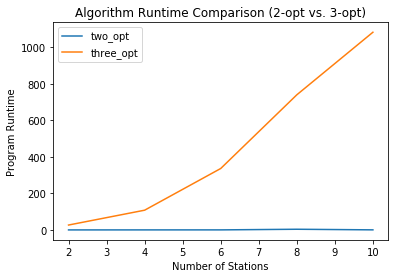

In [46]:
# summarize history for runtime
x = range(2, 12, 2)
plt.plot(x, two_opt_perf)
plt.plot(x, three_opt_perf)
plt.title('Algorithm Runtime Comparison (2-opt vs. 3-opt)')
plt.ylabel('Program Runtime')
plt.xlabel('Number of Stations')
plt.legend(['two_opt', 'three_opt'], loc='upper left')
plt.show()

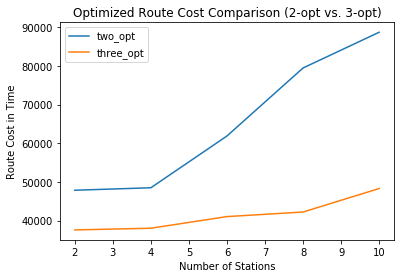

In [47]:
# summarize history for path costs
two_opt_cost = [47846.56589147287, 48486.99255813954, 61874.5846031746, 79458.27358378057, 88694.05769230769]
three_opt_cost = [37587.732558139534, 38025.214780361755, 41032.214780361755, 42212.71164416104, 48288.99255813954]
plt.plot(x, two_opt_cost)
plt.plot(x, three_opt_cost)
plt.title('Optimized Route Cost Comparison (2-opt vs. 3-opt)')
plt.ylabel('Route Cost in Time')
plt.xlabel('Number of Stations')
plt.legend(['two_opt', 'three_opt'], loc='upper left')
plt.show()